In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
def get_data():
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    ldata_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
    ldata_dir = pathlib.Path(ldata_dir)

    return ldata_dir

In [7]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("model.h5")
    print("Saved model to disk")


def retrieve_model():
    print('retrieving model')

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model from disk")

    return loaded_model

In [9]:
data_dir = get_data()
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [33]:
img_height = 180
img_width = 180
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
class_names = train_ds.class_names

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [34]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

'''for better performance'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2021-12-12 19:48:08.664189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-12 19:48:08.665937: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


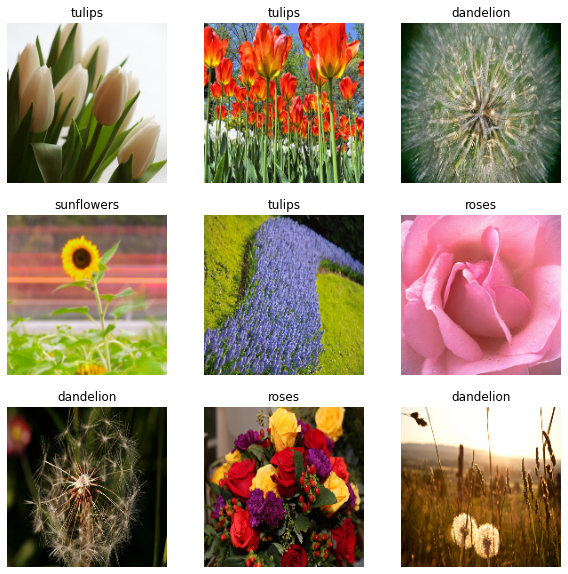

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
num_classes = len(class_names)
from tensorflow.python.keras.callbacks import TensorBoard 
from time import time

In [41]:
def generate_model(gene):
    model = Sequential()
    model.add(data_augmentation)
    model.add(layers.Rescaling(1./255, input_shape=(180,180,3)))
    for i in range (gene[0]):
        print('da')
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        if gene[i+1] == 1:
            model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes))
    
    model.compile(optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
''' train '''
# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = TensorBoard(log_dir=)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()), histogram_freq=1)

model = generate_model(np.array([5, 0, 0, 0, 0, 0]))

epochs = 20
# loss_history = LossHistory()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

2021-12-12 20:14:36.645173: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-12 20:14:36.645201: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-12 20:14:36.645802: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


da
da
da
da
da
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 18

2021-12-12 20:14:40.527085: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-12 20:14:40.527103: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/92 [..............................] - ETA: 3:23 - loss: 23.0088 - accuracy: 0.1562

2021-12-12 20:14:42.788774: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-12 20:14:42.791323: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-12 20:14:42.793466: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/1639332876.644951/train/plugins/profile/2021_12_12_20_14_42

2021-12-12 20:14:42.795022: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/1639332876.644951/train/plugins/profile/2021_12_12_20_14_42/192.168.1.3.trace.json.gz
2021-12-12 20:14:42.796982: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/1639332876.644951/train/plugins/profile/2021_12_12_20_14_42

2021-12-12 20:14:42.797136: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/1639332876.644951/train/plugins/profile/2021_12_12_20_

92/92 [==============================] - 226s 2s/step - loss: 1.9840 - accuracy: 0.3781 - val_loss: 1.1905 - val_accuracy: 0.5395
Epoch 2/20
64/92 [===================>..........] - ETA: 55s - loss: 1.1747 - accuracy: 0.5270